# OpenPIV example that you can execute in your browser

Thanks to the great service of mybinder.org

## Import what is necessary from OpenPIV

In [1]:
from openpiv import tools, process, validation, filters, scaling, pyprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/alex/anaconda3/envs/py27/lib/python2.7/site-packages/dask/array/numpy_compat.py:32: RuntimeWarning: divide by zero encountered in divide
  not np.allclose(np.divide(1, .5, dtype='i8'), 2) or


## Read a pair of PIV images

In [2]:
frame_a  = tools.imread( 'exp1_001_b.bmp' )
frame_b  = tools.imread( 'exp1_001_c.bmp' )

## Show them using matplotlib

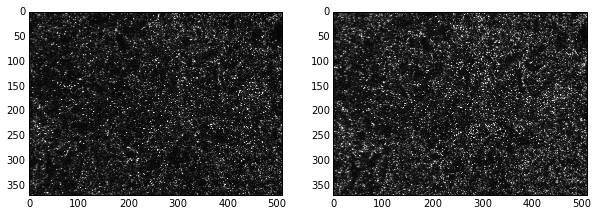

In [3]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)


## Define the PIV analysis parameters

1. Size of the interrogation window in frame A (winsize), 
2. Size of the search window in frame B (searchsize is larger or equal to winsize), 
3. overlap between the neighbouring windows (overlap), 
4. time interval of the PIV recording ($\Delta t$)
5. type of the peak quality (signal-to-noise ratio)

In [4]:
winsize = 24 # pixels
searchsize = 64  # pixels, search in image B
overlap = 12 # pixels
dt = 0.02 # sec

## Run the OpenPIV (fast code, precompiled in Cython)

In [5]:
u, v, sig2noise = process.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), 
                                                     window_size=winsize, overlap=overlap, dt=dt, 
                                                     search_area_size=searchsize, sig2noise_method='peak2peak' )

## Get a list of coordinates for the vector field

In [6]:
x, y = process.get_coordinates( image_size=frame_a.shape, window_size=winsize, overlap=overlap )

## Clean the peaks that are below a quality threshold

In [7]:
u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.3 )

## Replace those that are masked as bad vectors with local interpolation

In [8]:
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)

## Scale the results from pix/dt to mm/sec

In [9]:
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )

## store the result in a text file

In [10]:
tools.save(x, y, u, v, mask, 'exp1_001.txt' )

## plot the data stored in the text file

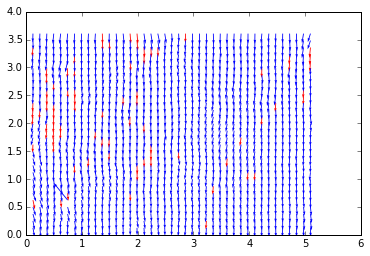

In [11]:
tools.display_vector_field('exp1_001.txt', scale=100, width=0.0025)

# Another example
## Use any pair of images that you can access via URL
For instance we can use images from PIV Challenge http://www.pivchallenge.org/

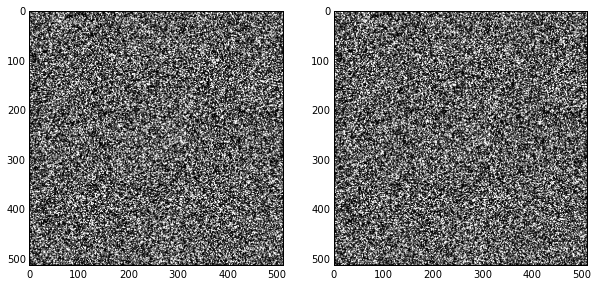

In [12]:
frame_a = tools.imread('http://www.pivchallenge.org/pub/B/B001_1.tif')
frame_b = tools.imread('http://www.pivchallenge.org/pub/B/B001_2.tif')
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

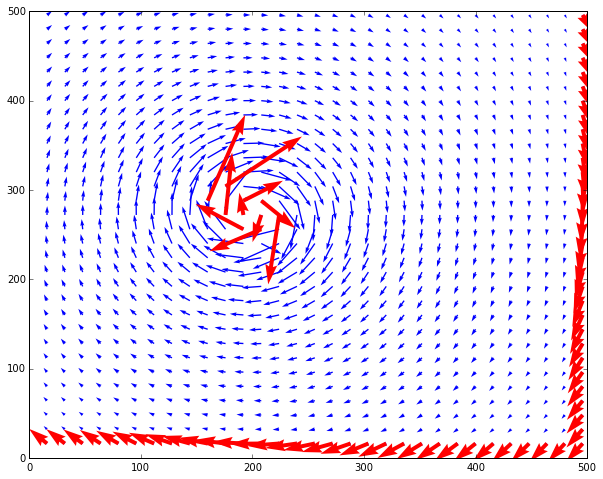

In [13]:
winsize = 32 # pixels
searchsize = 64  # pixels, search in image B
overlap = 16 # pixels
dt = 1.0 # sec
u0, v0, sig2noise = process.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method='peak2peak' )
x, y = process.get_coordinates( image_size=frame_a.shape, window_size=winsize, overlap=overlap )
u, v, mask = validation.sig2noise_val( u0, v0, sig2noise, threshold = 1.1 )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
# x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )

plt.figure(figsize=(10,8))
plt.quiver(x,y,u,v,color='b')
plt.quiver(x[mask],y[mask],u[mask],v[mask],color='r')

# How to use IpyWidgets to get an interactive GUI
## Import ipywidgets 
read more about those on https://ipywidgets.readthedocs.io/en/stable/index.html

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [15]:
def func(winsize,overlap,searchsize,s2n_method,s2n_threshold):
    if overlap >= winsize:
        overlap -= 1
        
    u, v, sig2noise = process.extended_search_area_piv(frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method=s2n_method )
    x, y = process.get_coordinates( image_size=frame_a.shape, window_size=winsize, overlap=overlap )
    u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = s2n_threshold )
    u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
    plt.figure(figsize=(10,8))
    plt.quiver(x,y,u,v,color='b')
    plt.quiver(x[mask],y[mask],u[mask],v[mask],color='r');

## Press Run interact to get PIV output for the values in the list 

In [16]:
interact_manual(func,winsize=[32,8,16,64,128],
                overlap=[16,8,32,64], 
                searchsize=[64,16,32,128,256],
                s2n_method=['peak2peak','peak2mean'],
                s2n_threshold=(1,10,.1));

interactive(children=(Dropdown(description=u'winsize', options=(32, 8, 16, 64, 128), value=32), Dropdown(description=u'overlap', options=(16, 8, 32, 64), value=16), Dropdown(description=u'searchsize', options=(64, 16, 32, 128, 256), value=64), Dropdown(description=u's2n_method', options=('peak2peak', 'peak2mean'), value='peak2peak'), FloatSlider(value=5.0, description=u's2n_threshold', max=10.0, min=1.0), Button(description=u'Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Let's say you want this GIF motion from the excellent JPIV website 

In [17]:
from IPython.display import Image
Image(url='http://www.jpiv.vennemann-online.de/fig/bode.gif')

In [18]:
# read it:
gif = tools.imread('http://www.jpiv.vennemann-online.de/fig/bode.gif')

# convert to gray scale
from skimage import img_as_uint
frame_a = img_as_uint(gif[0])
frame_b = img_as_uint(gif[1])

/Users/alex/anaconda3/envs/py27/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


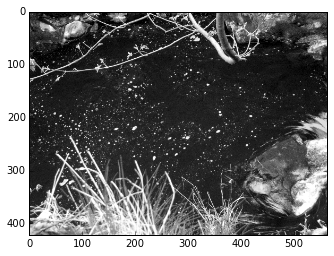

In [19]:
# see if this is what you want
plt.figure()
plt.imshow(frame_a,cmap=plt.cm.gray)

In [20]:
interact_manual(func,winsize=[64,8,16,64,128],
                overlap=[32,8,32,64], 
                searchsize=[64,16,32,128,256],
                s2n_method=['peak2peak','peak2mean'],
                s2n_threshold=(1.1,1.5,.1));

interactive(children=(Dropdown(description=u'winsize', options=(64, 8, 16, 64, 128), value=64), Dropdown(description=u'overlap', options=(32, 8, 32, 64), value=32), Dropdown(description=u'searchsize', options=(64, 16, 32, 128, 256), value=64), Dropdown(description=u's2n_method', options=('peak2peak', 'peak2mean'), value='peak2peak'), FloatSlider(value=1.2000000000000002, description=u's2n_threshold', max=1.5, min=1.1), Button(description=u'Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))